# 09 - Ensambles de árboles de decisión para regresión

![](images/portada_nb_FAV.png)

## Módulo 6 - Aprendizaje de máquina supervisado
### Profesor: M.Sc. Favio Vázquez

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

In [2]:
df = pd.read_csv("data/kc_house_data.csv")

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_above     21613 non-null  int64  
 3   sqft_living15  21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   view           21613 non-null  int64  
 6   sqft_basement  21613 non-null  int64  
 7   waterfront     21613 non-null  int64  
 8   yr_built       21613 non-null  int64  
 9   lat            21613 non-null  float64
 10  bedrooms       21613 non-null  int64  
 11  long           21613 non-null  float64
 12  price          21613 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 2.1 MB


In [14]:
df.select_dtypes(include = ['float64', 'int64']).columns

Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms',
       'view', 'sqft_basement', 'waterfront', 'yr_built', 'lat', 'bedrooms',
       'long', 'price'],
      dtype='object')

## Modelado

In [4]:
df = df[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long', "price"]]

In [5]:
X = df.drop("price", axis=1).values
y = df.price.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

## Decision Tree Regressor

In [15]:
from sklearn.tree  import DecisionTreeRegressor
decision=DecisionTreeRegressor()
start = time()
decision.fit(X_train, y_train)
end=time()
train_time_dec=end-start
decc=decision.score(X_test,y_test)
decpredict = decision.predict(X_test)
exp_dec = r2_score(decpredict,y_test)

## Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
rand_regr = RandomForestRegressor(n_estimators=100,random_state=0)
start = time()
rand_regr.fit(X_train, y_train)
end=time()
train_time_rand=end-start
random=rand_regr.score(X_test,y_test)
predictions = rand_regr.predict(X_test)
exp_rand = r2_score(predictions,y_test)

## Gradient Boosting Regressor

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
start = time()
est=GradientBoostingRegressor(n_estimators=100, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1).fit(X_train, y_train)
end=time()
train_time_g=end-start
gradient=est.score(X_test,y_test)
pred = est.predict(X_test)
exp_est = r2_score(pred,y_test)

## Comparar modelos

In [18]:
models_cross = pd.DataFrame({
    'Model': ['Gradient Boosting','Random Forest','Decision Tree'],
    'Score': [gradient,random,decc],
     '$R^2$': [exp_est,exp_rand,exp_dec]})
    
models_cross.sort_values(by='Score', ascending=False)

,Model,Score,$R^2$
0,Gradient Boosting,0.882049,0.870172
1,Random Forest,0.873304,0.854783
2,Decision Tree,0.751800,0.780619


Solo tomamos en cuenta **Score**

## Tiempo de entrenamiento por modelo

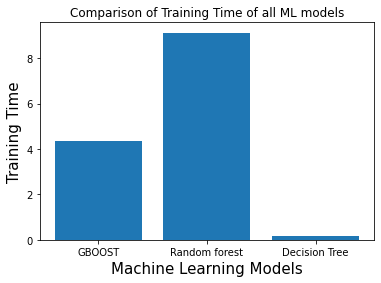

In [19]:
import matplotlib.pyplot as plt
import numpy as np
model = ['GBOOST', 'Random forest', 'Decision Tree']
Train_Time = [
    train_time_g,
    train_time_rand,
    train_time_dec
    
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=10, )
plt.title('Comparison of Training Time of all ML models')
plt.show()

## Curva de complejidad para GBR (lo veremos mejor después)

In [20]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(GradientBoostingRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Gradient Boosting Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

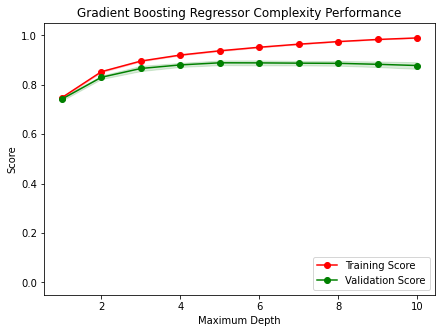

In [21]:
ModelComplexity(X, y)

A una profundidad máxima de 1, el modelo sufre un alto sesgo. Dos puntuaciones están bastante cerca, pero ambas puntuaciones están demasiado lejos del nivel aceptable. En otras palabras, el modelo no se ajusta bien. Los puntos de datos, obviamente, siguen algún tipo de curva, pero nuestro predictor no es lo suficientemente complejo para capturar esa información. Nuestro modelo está sesgado en el sentido de que asume que los datos se comportarán de cierta manera aunque esa suposición no sea cierta. Un punto clave es que nuestro entrenamiento no tiene nada de malo; este es el mejor ajuste posible que puede lograr un modelo lineal. Sin embargo, hay algo mal con el modelo en sí, ya que no es lo suficientemente complejo para modelar nuestros datos.

A una profundidad máxima de 10, el modelo sufre de una gran varianza, ya que la puntuación de entrenamiento es de 1,0 pero la puntuación de validación es de aproximadamente 0,7; en otras palabras, un modelo está sobreajustado. Nuevamente, los puntos de datos sugieren una especie de curva elegante. Sin embargo, nuestro modelo utiliza una curva muy compleja para acercarse lo más posible a cada punto de datos. En consecuencia, un modelo con alta varianza tiene un sesgo muy bajo porque hace poco o ningún supuesto sobre los datos. De hecho, se adapta demasiado a los datos.

Como vemos en la curva, la profundidad máxima de 5 generaliza mejor los datos no vistos. A medida que aumenta la profundidad máxima, el sesgo se reduce y la varianza aumenta. Debemos mantener el equilibrio entre los dos. Justo después de que el puntaje de entrenamiento de profundidad 5 aumente hacia arriba y el puntaje de validación comience a bajar, por lo que comienza a sufrir de sobreajuste. Por eso, 5 debería ser una buena opción.

Se cambia el valor del hiperparametro **max_depth**.

A profundidad 1 hay un subajuste,  a profundidad 10 hay un sobre ajuste.